In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import torch
from torch import nn
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import radius_graph, knn_graph

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
with h5py.File('data/train_xyze_1e4.h5', 'r') as f:
    # Access the dataset
    label_events = f['data']
    data = []
    for i, event in enumerate(label_events):
        pts = f['data'][i].reshape(-1,4)
        data.append(pts)
    
#     n_signal_events = 0
    
#     n_michel_voxels = np.zeros(len(label_events))

#     # Iterate and print each event (which is a variable-length array)
#     for i, event in enumerate(label_events):
#         print(f"Event {i}: {event} (length = {len(event)})")
#         n_signal_events += np.any(event == 2)
#         n_michel_voxels[i] = np.sum(event == 2)

# # Corrected the misplaced parenthesis in the print statement
# print("Fraction of events with Michel electrons:", (n_signal_events / len(label_events)) * 100, "%")

In [8]:
# Open the labels file
with h5py.File('data/train_label_1e4.h5', 'r') as f:
    # Access the dataset
    label_events = f['labels']
    
    labels = []

    for i, event in enumerate(label_events):
        labels.append(event)

In [9]:
# Define the training truth labels
# 2 is the label for Michel electrons
truth = [(event_labels == 2).astype(np.int32) for event_labels in labels]
# val_truth = torch.tensor([x for x_event in val_truth for x in x_event]).to(device)

In [ ]:
# from sklearn.neighbors import kneighbors_graph
# from scipy.spatial import distance

# def build_graph(points):
#     # Get adjacency matrix and indices of neighbors
#     edge1, edge2 = kneighbors_graph(points.numpy(), mode='connectivity', n_neighbors=3).tocoo().coords
#     edge_index = torch.tensor(np.vstack([edge1, edge2]), dtype=torch.long)

#     edge_distances = points[edge1] - points[edge2]
#     edge_attr = torch.tensor(edge_distances, dtype=torch.float).view(-1, 1)  # Reshape to [num_edges, 1]

#     edge_index, edge_attr


In [20]:
# Input: sparse tensor with coordinates and features
# coordinates: Nx4 tensor (batch_idx, x, y, z)
# features: Nx1 tensor (voxel values)
# Iterate over the events and create sparse tensors
# Example input data

train_data = []
val_data = []
test_data = []

# Iterate over all the events and create sparse tensors that are then merged
# For each input_coords, add another column for the batch index, which is just the index of the event
for i, (event_coords, input_labels) in enumerate(zip(tqdm(data), truth)):
    # if i >= 2000:
    #     break
    
    # For now, only use parts of the dataset to save memory
    # if i >= 5000:
    #     break
    
    # Use the first three columns as coordinates
    input_coords = torch.tensor(event_coords[:, :3], dtype=torch.int32)  
    # input_coords = torch.cat((torch.full((input_coords.shape[0], 1), i, dtype=torch.int32), input_coords), dim=1)  # Add batch index
    # Use the fourth column as features
    input_features = torch.tensor(event_coords[:, 3], dtype=torch.float32).unsqueeze(1)
    
    edge_index = knn_graph(input_coords, k=3, loop=False)
    # Compute the edge attributes (distances)
    row, col = edge_index
    edge_attr = input_coords[row] - input_coords[col]
    edge_attr = torch.norm(edge_attr.to(torch.float32), p=2, dim=1).view(-1, 1)  # Reshape to [num_edges, 1]
    # edge_index = radius_graph(input_coords, r=3.0, loop=False)
    
    event_data = Data(
        x=input_features,
        edge_index=edge_index,
        y=torch.tensor(input_labels, dtype=torch.float32),
        edge_attr=edge_attr,
    )

    if i < 500:
        val_data.append(event_data)
        continue
    if i < 1000:
        test_data.append(event_data)
        continue

    train_data.append(event_data)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [02:04<00:00, 80.61it/s]


In [21]:
with open('data/gnn_train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)

In [22]:
with open('data/gnn_val_data.pkl', 'wb') as f:
    pickle.dump(val_data, f)

In [23]:
with open('data/gnn_test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)

In [3]:
with open('data/gnn_train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
# with open('data/gnn_train_data_1.pkl', 'rb') as f:
#     train_data1 = pickle.load(f)
with open('data/gnn_val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)
# with open('data/gnn_test_data.pkl', 'rb') as f:
#     test_data = pickle.load(f)

len(train_data), len(val_data)#, len(test_data)

(9000, 500)

(array([ 18.,  73., 176., 358., 419., 545., 624., 642., 670., 668., 512.,
        497., 399., 329., 318., 263., 206., 185., 165., 149., 158., 143.,
        143., 106., 130., 100., 115., 103., 108.,  96., 101.,  72.,  61.,
         63.,  44.,  54.,  54.,  26.,  27.,  25.,  13.,  13.,   7.,   7.,
          8.,   5.,   0.,   0.,   1.,   1.]),
 array([  120.  ,   441.94,   763.88,  1085.82,  1407.76,  1729.7 ,
         2051.64,  2373.58,  2695.52,  3017.46,  3339.4 ,  3661.34,
         3983.28,  4305.22,  4627.16,  4949.1 ,  5271.04,  5592.98,
         5914.92,  6236.86,  6558.8 ,  6880.74,  7202.68,  7524.62,
         7846.56,  8168.5 ,  8490.44,  8812.38,  9134.32,  9456.26,
         9778.2 , 10100.14, 10422.08, 10744.02, 11065.96, 11387.9 ,
        11709.84, 12031.78, 12353.72, 12675.66, 12997.6 , 13319.54,
        13641.48, 13963.42, 14285.36, 14607.3 , 14929.24, 15251.18,
        15573.12, 15895.06, 16217.  ]),
 <BarContainer object of 50 artists>)

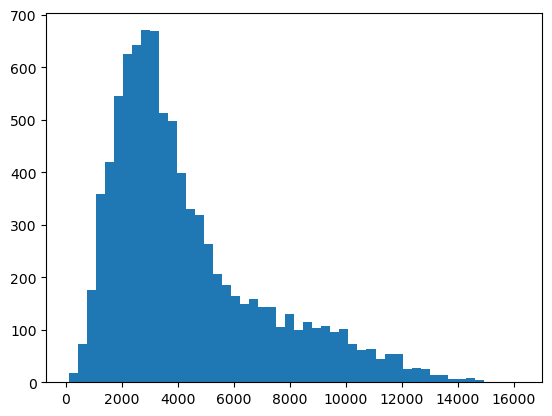

In [4]:
plt.hist([t.y.shape[0] for t in train_data], bins=50)

In [5]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [6]:
train_n_nodes = sum(len(d.x) for d in train_loader)
val_n_nodes = sum(len(d.x) for d in val_loader)
print(f"Train nodes: {train_n_nodes}, Val nodes: {val_n_nodes}")

Train nodes: 39427959, Val nodes: 2187515


In [7]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, heads=1):
        super(GNN, self).__init__()
        self.conv1 = GATConv(in_channels=1, out_channels=hidden_dim, heads=heads, edge_dim=1)
        self.conv2 = GATConv(in_channels=hidden_dim * heads, out_channels=hidden_dim, heads=1, edge_dim=1)
        self.conv3 = GATConv(in_channels=hidden_dim, out_channels=output_dim, heads=1, concat=False, edge_dim=1)

    def forward(self, x, edge_index, edge_attr):
        # Layer 1
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        # Layer 2
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        # Output layer
        x = self.conv3(x, edge_index, edge_attr)
        return x


In [28]:
# Initialize model
model = GNN(hidden_dim=4, output_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

train_loss_list = []
val_loss_list = []

# Training loop with validation
best_val_f1 = 0.0
for epoch in range(100):
    # Training
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        out = model(batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(device))
        weight = batch.y.unsqueeze(1) + 0.1
        loss = F.binary_cross_entropy_with_logits(out, batch.y.unsqueeze(1).to(device), reduction="none").cpu()
        loss = (loss * weight).sum()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Divide by the total number of nodes in all batches
    train_loss /= train_n_nodes
    
    train_loss_list.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    preds = []

    with torch.no_grad():
        for batch in val_loader:
            weight = batch.y.unsqueeze(1) + 0.1
            out = model(batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(device))
            loss = F.binary_cross_entropy_with_logits(out, batch.y.unsqueeze(1).to(device), reduction="none").cpu()
            loss = (loss * weight).sum().item()
            preds.append(out)
            val_loss += loss

    val_loss /= val_n_nodes
    val_loss_list.append(val_loss)

    val_f1 = f1_score(
        torch.cat([batch.y for batch in val_loader]).cpu().numpy(),
        torch.cat([F.sigmoid(batch) > 0.5 for batch in preds]).squeeze().cpu().numpy(),
        # average='macro'
    )

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pt")
    
    # Save best model
    # if val_f1 > best_val_f1:
    #     best_val_f1 = val_f1
    #     torch.save(model.state_dict(), "best_model.pt")

100%|██████████| 282/282 [00:08<00:00, 34.86it/s]


Epoch 1, Train Loss: 0.0508, Val Loss: 0.0502, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.38it/s]


Epoch 2, Train Loss: 0.0485, Val Loss: 0.0483, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.04it/s]


Epoch 3, Train Loss: 0.0471, Val Loss: 0.0476, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.56it/s]


Epoch 4, Train Loss: 0.0467, Val Loss: 0.0474, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.86it/s]


Epoch 5, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.92it/s]


Epoch 6, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.93it/s]


Epoch 7, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.51it/s]


Epoch 8, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.55it/s]


Epoch 9, Train Loss: 0.0466, Val Loss: 0.0474, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.27it/s]


Epoch 10, Train Loss: 0.0466, Val Loss: 0.0474, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.22it/s]


Epoch 11, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.52it/s]


Epoch 12, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.43it/s]


Epoch 13, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.42it/s]


Epoch 14, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.37it/s]


Epoch 15, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 31.88it/s]


Epoch 16, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.21it/s]


Epoch 17, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.94it/s]


Epoch 18, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 35.10it/s]


Epoch 19, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.43it/s]


Epoch 20, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.81it/s]


Epoch 21, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 31.46it/s]


Epoch 22, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.71it/s]


Epoch 23, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 35.07it/s]


Epoch 24, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.84it/s]


Epoch 25, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.45it/s]


Epoch 26, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.89it/s]


Epoch 27, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.34it/s]


Epoch 28, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.50it/s]


Epoch 29, Train Loss: 0.0466, Val Loss: 0.0474, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 32.88it/s]


Epoch 30, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 32.39it/s]


Epoch 31, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 31.95it/s]


Epoch 32, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.61it/s]


Epoch 33, Train Loss: 0.0465, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 36.29it/s]


Epoch 34, Train Loss: 0.0466, Val Loss: 0.0475, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 36.44it/s]


Epoch 35, Train Loss: 0.0466, Val Loss: 0.0474, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 36.34it/s]


Epoch 36, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 36.72it/s]


Epoch 37, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 36.35it/s]


Epoch 38, Train Loss: 0.0466, Val Loss: 0.0478, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 36.66it/s]


Epoch 39, Train Loss: 0.0466, Val Loss: 0.0476, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 36.20it/s]


Epoch 40, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.14it/s]


Epoch 41, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.11it/s]


Epoch 42, Train Loss: 0.0466, Val Loss: 0.0474, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.17it/s]


Epoch 43, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 32.02it/s]


Epoch 44, Train Loss: 0.0465, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.50it/s]


Epoch 45, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.64it/s]


Epoch 46, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 31.97it/s]


Epoch 47, Train Loss: 0.0466, Val Loss: 0.0474, Val F1: 0.0000


100%|██████████| 282/282 [00:09<00:00, 30.25it/s]


Epoch 48, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.59it/s]


Epoch 49, Train Loss: 0.0465, Val Loss: 0.0474, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.44it/s]


Epoch 50, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.70it/s]


Epoch 51, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 31.39it/s]


Epoch 52, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 32.48it/s]


Epoch 53, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 32.94it/s]


Epoch 54, Train Loss: 0.0465, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 32.25it/s]


Epoch 55, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:09<00:00, 30.23it/s]


Epoch 56, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:09<00:00, 29.32it/s]


Epoch 57, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 32.98it/s]


Epoch 58, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.89it/s]


Epoch 59, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 32.72it/s]


Epoch 60, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.19it/s]


Epoch 61, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.20it/s]


Epoch 62, Train Loss: 0.0466, Val Loss: 0.0474, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.67it/s]


Epoch 63, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.40it/s]


Epoch 64, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.81it/s]


Epoch 65, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.83it/s]


Epoch 66, Train Loss: 0.0465, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 36.06it/s]


Epoch 67, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 36.17it/s]


Epoch 68, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 36.57it/s]


Epoch 69, Train Loss: 0.0465, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 36.56it/s]


Epoch 70, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 36.66it/s]


Epoch 71, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 36.51it/s]


Epoch 72, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.75it/s]


Epoch 73, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.58it/s]


Epoch 74, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 32.03it/s]


Epoch 75, Train Loss: 0.0465, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.71it/s]


Epoch 76, Train Loss: 0.0465, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.36it/s]


Epoch 77, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.17it/s]


Epoch 78, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 33.09it/s]


Epoch 79, Train Loss: 0.0466, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.59it/s]


Epoch 80, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.72it/s]


Epoch 81, Train Loss: 0.0466, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.97it/s]


Epoch 82, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.63it/s]


Epoch 83, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.89it/s]


Epoch 84, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.29it/s]


Epoch 85, Train Loss: 0.0465, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 35.20it/s]


Epoch 86, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.03it/s]


Epoch 87, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.44it/s]


Epoch 88, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 32.31it/s]


Epoch 89, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 35.11it/s]


Epoch 90, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.97it/s]


Epoch 91, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.57it/s]


Epoch 92, Train Loss: 0.0465, Val Loss: 0.0473, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.58it/s]


Epoch 93, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.99it/s]


Epoch 94, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.87it/s]


Epoch 95, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.79it/s]


Epoch 96, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.79it/s]


Epoch 97, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:07<00:00, 35.43it/s]


Epoch 98, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.82it/s]


Epoch 99, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


100%|██████████| 282/282 [00:08<00:00, 34.31it/s]


Epoch 100, Train Loss: 0.0465, Val Loss: 0.0472, Val F1: 0.0000


In [ ]:
# Save training and test loss
with open("train_loss.txt") as f:
    f.writelines(train_loss_list)

with open("val_loss.txt") as f:
    f.writelines(val_loss_list)

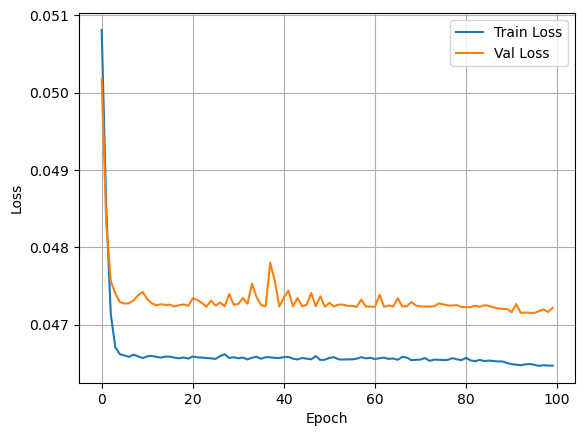

In [ ]:
# Plot the training and validation loss
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [8]:
model = GNN(hidden_dim=4, output_dim=1).to(device)
# Load model
model.load_state_dict(torch.load("model_epoch_95.pt"))

<All keys matched successfully>

In [10]:
model.eval()
preds = []

with torch.no_grad():
    for batch in val_loader:
        weight = batch.y.unsqueeze(1) + 0.1
        out = model(batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(device))
        preds.append(out)


Text(0.5, 1.0, 'Distribution of Predictions')

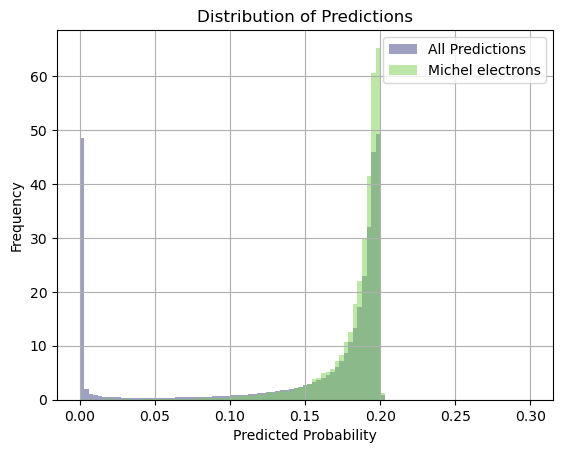

In [11]:
preds_flat = torch.cat([F.sigmoid(batch) for batch in preds]).squeeze()
preds_only_truth = torch.cat([F.sigmoid(batch)[batch2.y == 1] for batch2, batch in zip(val_loader, preds)]).squeeze().cpu()
# plot the distribution of predictions
bins = np.linspace(0., 0.3, 100)
plt.hist(
    preds_flat.cpu().numpy(), 
    density=True, bins=bins, alpha=0.5, label="All Predictions", color=plt.cm.viridis(0.2),
)
# plot the distribution of predictions for only nodes with label 1
plt.hist(
    preds_only_truth.cpu().numpy(), 
    density=True, bins=bins, alpha=0.5, label="Michel electrons", color=plt.cm.viridis(0.8),
)

plt.legend()
plt.grid()
# plt.xlim(0, 0.1)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions')

In [13]:
preds_flat.min(), preds_flat.max()

(tensor(7.9618e-11, device='cuda:0'), tensor(0.2005, device='cuda:0'))

In [ ]:
# Plot the F1 score as a function of the cut value
cut_values = np.linspace(0., 0.2, 10)
f1_scores = []
for cut in cut_values:
    preds_cut = preds_flat > cut
    f1 = f1_score(
        torch.cat([batch.y for batch in val_loader]).cpu().numpy(),
        preds_cut.cpu().numpy(),
        # average='macro'
    )
    f1_scores.append(f1)

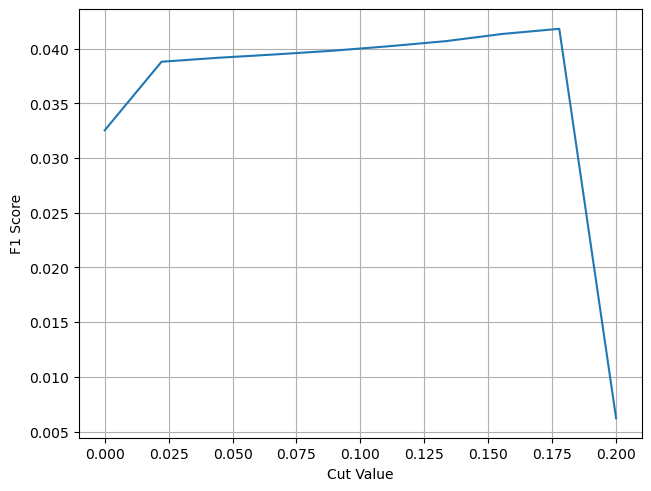

In [17]:
fig, ax = plt.subplots(layout="constrained")
ax.plot(cut_values, f1_scores, label='F1 Score')
ax.set_xlabel('Cut Value')
ax.set_ylabel('F1 Score')
ax.grid()

In [ ]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GNN(input_dim=1, hidden_dim=4, output_dim=1)
model.load_state_dict(torch.load("model_epoch_5.pt"))